# Rossman Store Sale - Prophet Model

In [ ]:
# https://facebook.github.io/prophet/docs/installation.html#python
    

In [ ]:
# ttps://facebook.github.io/prophet/docs/installation.html#python


In [ ]:
# dataset taken from
# https://www.kaggle.com/c/rossmann-store-sales/overview


# Reading the dataset

In [11]:
# calling all libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import datetime
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric
plt.rcParams['figure.figsize'] = (12,8)

In [12]:
# ignore harmless warnings
import warnings
warnings.filterwarnings('ignore')

In [13]:
# reading train dataset datasets

# sales_train = pd.read_csv('../Data Science for Business Package/3. Sales Department Data/train.csv')
df = pd.read_csv('train.csv')

In [14]:
print(df.info())
df.head()
# observations
# almost 1 million transactions with 8 columnsß

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB
None


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


# Data preparation

In [15]:
# !pip install fbprophet

In [16]:
# checking the biggest store 

biggest_stores = df['Store'].value_counts(ascending = False)
biggest_stores


1023    942
666     942
675     942
163     942
674     942
       ... 
900     758
902     758
903     758
904     758
512     758
Name: Store, Length: 1115, dtype: int64

In [17]:
# let's search only for store = 85
df = df[df['Store'] == 1023]
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 942 entries, 1022 to 1017116
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Store          942 non-null    int64 
 1   DayOfWeek      942 non-null    int64 
 2   Date           942 non-null    object
 3   Sales          942 non-null    int64 
 4   Customers      942 non-null    int64 
 5   Open           942 non-null    int64 
 6   Promo          942 non-null    int64 
 7   StateHoliday   942 non-null    object
 8   SchoolHoliday  942 non-null    int64 
dtypes: int64(7), object(2)
memory usage: 73.6+ KB
None


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1022,1023,5,2015-07-31,7182,649,1,1,0,1
2137,1023,4,2015-07-30,6348,603,1,1,0,1
3252,1023,3,2015-07-29,6010,544,1,1,0,1
4367,1023,2,2015-07-28,6470,588,1,1,0,1
5482,1023,1,2015-07-27,8230,701,1,1,0,1


In [18]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by = 'Date', ascending = True, inplace = True)
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1017116,1023,2,2013-01-01,0,0,0,0,a,1
1016002,1023,3,2013-01-02,4937,640,1,0,0,1
1014887,1023,4,2013-01-03,4752,588,1,0,0,0
1013772,1023,5,2013-01-04,5010,634,1,0,0,0
1012657,1023,6,2013-01-05,6055,692,1,0,0,0


In [8]:
# checking for weekly
# print(len(df))
# df = df.resample(rule = 'W').sum()
# # df.index.freq = 'W'
# print(len(df))

In [9]:
df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday'],
      dtype='object')

In [19]:
df_prophet = df[['Date', 'Sales']].copy()
df_prophet.columns = ['ds', 'y']
df_prophet

,ds,y
1017116,2013-01-01,0
1016002,2013-01-02,4937
1014887,2013-01-03,4752
1013772,2013-01-04,5010
1012657,2013-01-05,6055
...,...,...
5482,2015-07-27,8230
4367,2015-07-28,6470
3252,2015-07-29,6010
2137,2015-07-30,6348


In [20]:
df_prophet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 942 entries, 1017116 to 1022
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      942 non-null    datetime64[ns]
 1   y       942 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 22.1 KB


In [21]:
# split the data into train and test
train = df_prophet.iloc[:-90]
test = df_prophet.iloc[-90:]
print(len(df_prophet), len(train), len(test))

942 852 90


In [22]:
df_prophet.tail()

,ds,y
5482,2015-07-27,8230
4367,2015-07-28,6470
3252,2015-07-29,6010
2137,2015-07-30,6348
1022,2015-07-31,7182


# Prophet Model

In [23]:
# create and fit model

m = Prophet()
m.fit(train)



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


# Forecasting

In [24]:
# forecast for 90 days
future = m.make_future_dataframe(periods = 90, freq = 'D')

In [25]:
future

,ds
0,2013-01-01
1,2013-01-02
2,2013-01-03
3,2013-01-04
4,2013-01-05
...,...
937,2015-07-27
938,2015-07-28
939,2015-07-29
940,2015-07-30


In [26]:
# forecast the future

forecast = m.predict(future)


In [27]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-01,5542.570002,3648.172367,8251.321857,5542.570002,5542.570002,444.577263,444.577263,444.577263,689.262037,689.262037,689.262037,-244.684774,-244.684774,-244.684774,0.0,0.0,0.0,5987.147265
1,2013-01-02,5541.590741,3539.107786,8039.437780,5541.590741,5541.590741,107.838817,107.838817,107.838817,485.266570,485.266570,485.266570,-377.427753,-377.427753,-377.427753,0.0,0.0,0.0,5649.429558
2,2013-01-03,5540.611481,2932.536275,7631.270745,5540.611481,5540.611481,-151.562361,-151.562361,-151.562361,341.812082,341.812082,341.812082,-493.374443,-493.374443,-493.374443,0.0,0.0,0.0,5389.049120
3,2013-01-04,5539.632220,3336.750501,7991.460290,5539.632220,5539.632220,199.479846,199.479846,199.479846,791.397075,791.397075,791.397075,-591.917229,-591.917229,-591.917229,0.0,0.0,0.0,5739.112066
4,2013-01-05,5538.652959,3386.436137,8000.124512,5538.652959,5538.652959,128.668907,128.668907,128.668907,801.454194,801.454194,801.454194,-672.785287,-672.785287,-672.785287,0.0,0.0,0.0,5667.321866


In [28]:
forecast.head(3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-01,5542.570002,3648.172367,8251.321857,5542.570002,5542.570002,444.577263,444.577263,444.577263,689.262037,689.262037,689.262037,-244.684774,-244.684774,-244.684774,0.0,0.0,0.0,5987.147265
1,2013-01-02,5541.590741,3539.107786,8039.437780,5541.590741,5541.590741,107.838817,107.838817,107.838817,485.266570,485.266570,485.266570,-377.427753,-377.427753,-377.427753,0.0,0.0,0.0,5649.429558
2,2013-01-03,5540.611481,2932.536275,7631.270745,5540.611481,5540.611481,-151.562361,-151.562361,-151.562361,341.812082,341.812082,341.812082,-493.374443,-493.374443,-493.374443,0.0,0.0,0.0,5389.049120


In [29]:
forecast.tail(3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
939,2015-07-29,4838.790773,3120.801852,7688.466739,4836.338269,4841.273628,584.874604,584.874604,584.874604,485.266570,485.266570,485.266570,99.608035,99.608035,99.608035,0.0,0.0,0.0,5423.665378
940,2015-07-30,4838.335593,3047.942121,7625.795837,4835.828797,4840.867096,423.503114,423.503114,423.503114,341.812082,341.812082,341.812082,81.691032,81.691032,81.691032,0.0,0.0,0.0,5261.838707
941,2015-07-31,4837.880413,3255.761698,7915.447089,4835.328529,4840.477220,855.827144,855.827144,855.827144,791.397075,791.397075,791.397075,64.430069,64.430069,64.430069,0.0,0.0,0.0,5693.707557


In [30]:
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [31]:
forecast[['ds','yhat_lower', 'yhat_upper','yhat']].tail()

,ds,yhat_lower,yhat_upper,yhat
937,2015-07-27,4753.101044,9378.813771,6980.701556
938,2015-07-28,3227.887107,7970.783150,5646.280372
939,2015-07-29,3120.801852,7688.466739,5423.665378
940,2015-07-30,3047.942121,7625.795837,5261.838707
941,2015-07-31,3255.761698,7915.447089,5693.707557


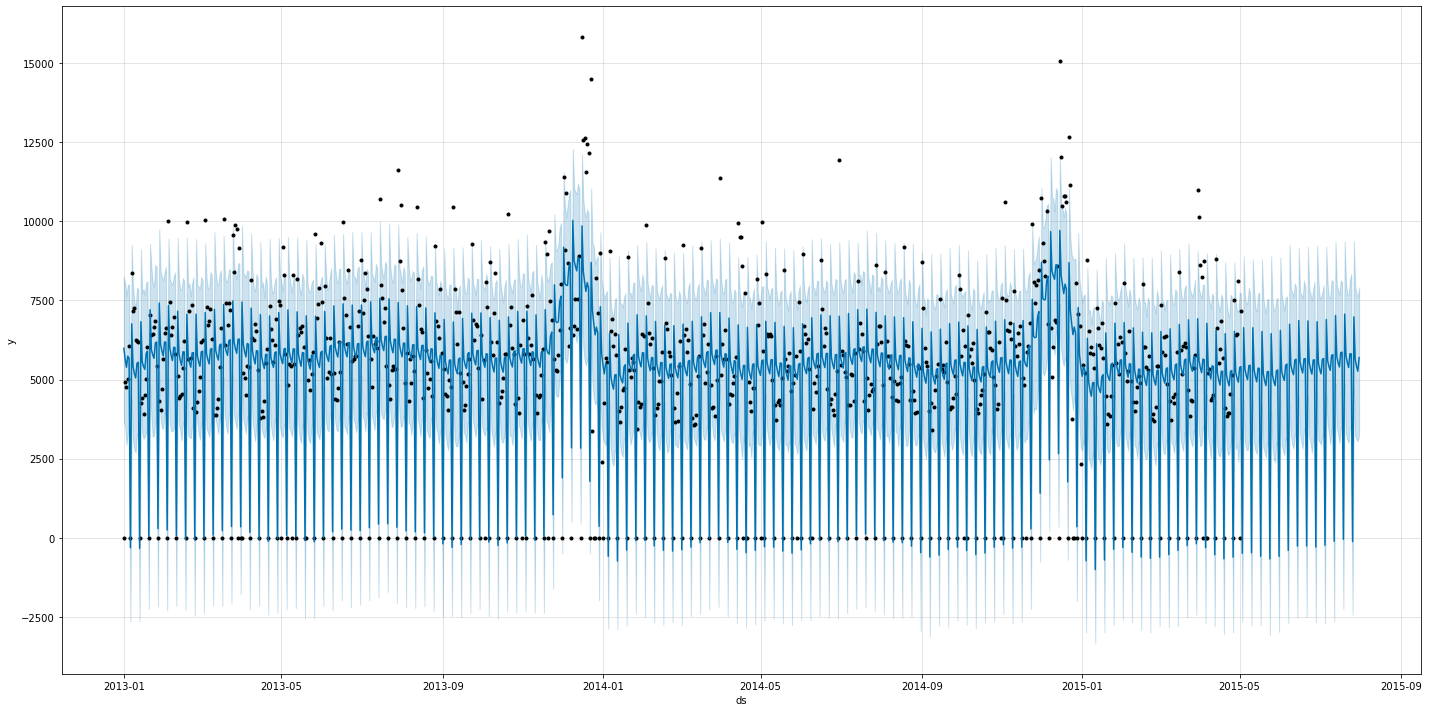

In [32]:
# plotting forecast

m.plot(forecast, figsize = (20,10),); # prophet's built-in tool


<AxesSubplot:xlabel='ds'>

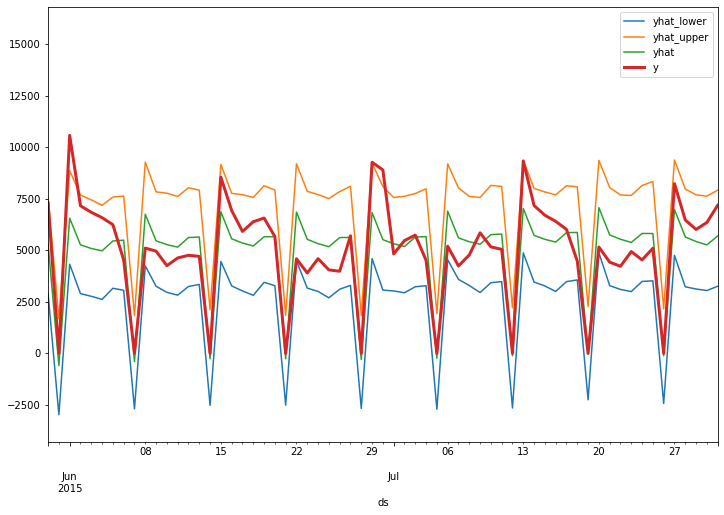

In [45]:
ax = forecast.plot(x ='ds', y ='yhat_lower',xlim=('2015-05-30', '2015-07-31'))
forecast.plot(ax = ax, x ='ds', y ='yhat_upper',xlim=('2015-05-30', '2015-07-31'))
forecast.plot(ax = ax, x ='ds', y ='yhat',xlim=('2015-05-30', '2015-07-31'))
df_prophet.plot(linewidth = 3,ax = ax, x ='ds', y ='y',xlim=('2015-05-30', '2015-07-31'))


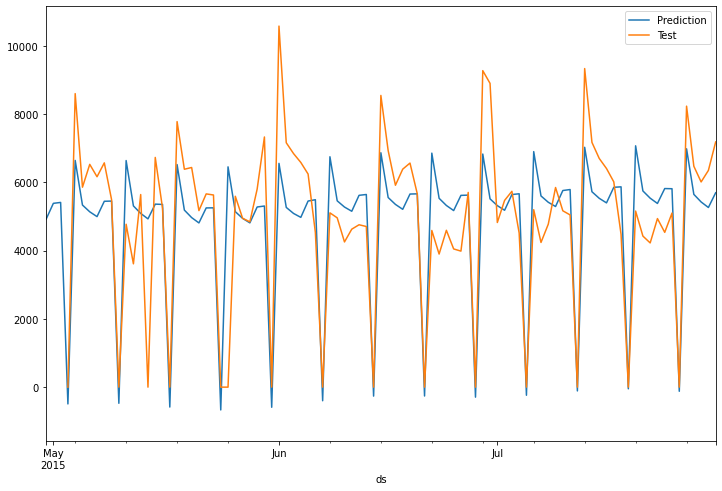

In [33]:
ax = forecast.plot(x = 'ds', y= 'yhat', label = 'Prediction', legend = True, figsize = (12,8))
test.plot( x ='ds', y='y',ax = ax, label = 'Test', legend=True, xlim=('2015-04-30', '2015-07-31'));

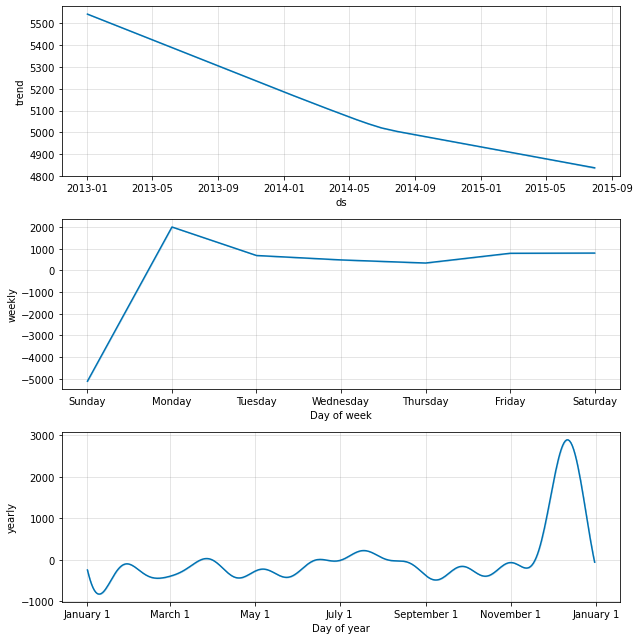

In [34]:
m.plot_components(forecast);

# Prophet Diagnosis

In [26]:
# Tutorial from here
# https://facebook.github.io/prophet/docs/diagnostics.html


df_cv = cross_validation(m, initial = 5*365, period = str(5*365)+' days', horizon = str(365)+ ' days')


INFO:fbprophet:Making 1 forecasts with cutoffs between 2014-05-02 00:00:00 and 2014-05-02 00:00:00


In [27]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2014-05-03,6363.803548,4606.892299,8247.206150,5885,2014-05-02
1,2014-05-04,12052.541630,10288.312655,13771.090142,8298,2014-05-02
2,2014-05-05,8383.979518,6514.006251,10054.041094,9165,2014-05-02
3,2014-05-06,7351.271928,5592.963522,9207.607861,7453,2014-05-02
4,2014-05-07,7361.907058,5572.838467,9006.159797,7044,2014-05-02


In [28]:
df_cv.shape

(365, 6)

In [29]:
performance_metrics(df_cv)

,horizon,mse,rmse,mae,mape,mdape,coverage
0,36 days,3.180462e+06,1783.385120,1127.598723,0.154807,0.094339,0.805556
1,37 days,3.196667e+06,1787.922620,1139.339117,0.154575,0.094339,0.805556
2,38 days,3.520863e+06,1876.396406,1176.051408,0.153010,0.094339,0.805556
3,39 days,3.504054e+06,1871.911776,1156.289099,0.150929,0.093992,0.805556
4,40 days,3.517683e+06,1875.548753,1173.124965,0.153851,0.106898,0.805556
...,...,...,...,...,...,...,...
325,361 days,3.927104e+06,1981.692311,1383.876562,0.168408,0.141425,0.777778
326,362 days,3.902487e+06,1975.471336,1367.857800,0.164718,0.133020,0.777778
327,363 days,4.071049e+06,2017.684129,1413.188474,0.166962,0.133020,0.750000
328,364 days,4.561966e+06,2135.875927,1512.884380,0.174192,0.141425,0.722222


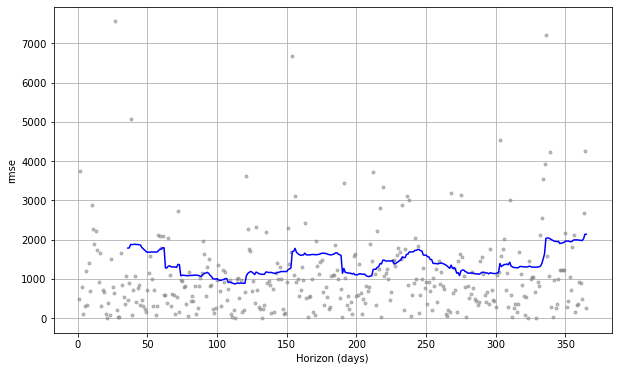

In [30]:
# plot rmse
plot_cross_validation_metric(df_cv, metric = 'rmse');


### Comparision to ARIMA, SARIMAX, and RNN model, Facebook's Prophecy is giving me least root mean square error in this application.